In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import random
import time
import math
import d2l
import os

from mxnet import autograd, np, npx, gluon, init
from mxnet.gluon import loss as gloss
from mxnet.gluon import rnn
from mxnet.gluon import nn
npx.set_np()

#  09. Modern Recurrent Neural Networks
Although we have learned the basics of recurrent neural networks, they are not sufficient for a practitioner to solve today's sequence learning problems. For instance, given the numerical unstability during gradient calculation, gated recurrent neural networks are much more common in practice. We will begin by introducing two of such widely-used networks, namely `gated recurrent units` (`GRU`) and `long short term memory` (`LSTM`), with illustrations using the same language modeling problem as introduced in `Chapter 8`.

Furthermore, we will modify recurrent neural networks with a single undirectional hidden layer. We will describe deep architectures, and discuss the bidirectional design with both forward and backward recursion. They are frequently adopted in modern recurrent networks.

In fact, a large portion of sequence learning problems such as automatic speech recognition, text to speech, and machine translation, consider both inputs and outputs to be sequences of arbitrary length. Finally, we will take machine translation as an example, and introduce the encoder-decoder architecture based on recurrent neural networks and modern practices for such sequence to sequence learning problems.


## 9.2 Long Short Term Memory (LSTM)
The challenge to address long-term information preservation and short-term input skipping in latent variable models has existed for a long time. One of the earliest approaches to address this was the `LSTM` (`Hochreiter & Schmidhuber, 1997`). It shares many of the properties of the `Gated Recurrent Unit` (`GRU`). Interestingly, `LSTM`'s design is slightly more complex than `GRU` but predates `GRU` by almost two decades.

Arguably it is inspired by logic gates of a computer. To control a memory cell we need a number of gates. One gate is needed to read out the entries from the cell (as opposed to reading any other cell). We will refer to this as the output gate. A second gate is needed to decide when to read data into the cell. We refer to this as the input gate. Last, we need a mechanism to reset the contents of the cell, governed by a forget gate. The motivation for such a design is the same as before, namely to be able to decide when to remember and when to ignore inputs in the latent state via a dedicated mechanism. Let us see how this works in practice.

### 9.2.1 Gated Memory Cells
Three gates are introduced in `LSTM`: the input gate, the forget gate, and the output gate. In addition to that we will introduce the memory cell that has the same shape as the hidden state. Strictly speaking this is just a fancy version of a hidden state, engineered to record additional information.

##### Input Gates, Forget Gates, and Output Gates
Just like with `GRU`, the data feeding into the `LSTM` gates is the input at the current timestep $\mathbf{X}_t$ and the hidden state of the previous timestep $\mathbf{H}_{t-1}$. These inputs are processed by a fully connected layer and a sigmoid activation function to compute the values of input, forget and output gates. As a result, the three gates' all output values are in the range of $[0, 1]$. `Fig. 9.2.1` the data flow for the input, forget, and output gates.

<img src="images/09_05.png" style="width:450px;"/>

We assume that there are $h$ hidden units, the minibatch is of size $n$, and number of inputs is $d$. Thus, the input is $\mathbf{X}_t \in \mathbb{R}^{n \times d}$ and the hidden state of the last timestep is $\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$. Correspondingly, the gates are defined as follows: the input gate is $\mathbf{I}_t \in \mathbb{R}^{n \times h}$, the forget gate is $\mathbf{F}_t \in \mathbb{R}^{n \times h}$, and the output gate is $\mathbf{O}_t \in \mathbb{R}^{n \times h}$. They are calculated as follows:

$$ \begin{aligned} \mathbf{I}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xi} + \mathbf{H}_{t-1} \mathbf{W}_{hi} + \mathbf{b}_i),\\ \mathbf{F}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xf} + \mathbf{H}_{t-1} \mathbf{W}_{hf} + \mathbf{b}_f),\\ \mathbf{O}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xo} + \mathbf{H}_{t-1} \mathbf{W}_{ho} + \mathbf{b}_o), \end{aligned} $$

where $\mathbf{W}_{xi}, \mathbf{W}_{xf}, \mathbf{W}_{xo} \in \mathbb{R}^{d \times h}$ and $\mathbf{W}_{hi}, \mathbf{W}_{hf}, \mathbf{W}_{ho} \in \mathbb{R}^{h \times h}$ are weight parameters and $\mathbf{b}_i, \mathbf{b}_f, \mathbf{b}_o \in \mathbb{R}^{1 \times h}$ are bias parameters.

##### Candidate Memory Cell
Next we design the memory cell. Since we have not specified the action of the various gates yet, we first introduce the candidate memory cell $\tilde{\mathbf{C}}_t \in \mathbb{R}^{n \times h}$. Its computation is similar to the three gates described above, but using a $\tanh$ function with a value range for $[-1, 1]$ as the activation function. This leads to the following equation at timestep $t$.

$$\tilde{\mathbf{C}}_t = \text{tanh}(\mathbf{X}_t \mathbf{W}_{xc} + \mathbf{H}_{t-1} \mathbf{W}_{hc} + \mathbf{b}_c).$$

Here $\mathbf{W}_{xc} \in \mathbb{R}^{d \times h}$ and $\mathbf{W}_{hc} \in \mathbb{R}^{h \times h}$ are weight parameters and $\mathbf{b}_c \in \mathbb{R}^{1 \times h}$ is a bias parameter.

A quick illustration of the candidate memory cell is shown in `Fig. 9.2.2`.

<img src="images/09_06.png" style="width:450px;"/>

##### Memory Cell
In `GRU`, we had a single mechanism to govern input and forgetting. Here in `LSTM` we have two parameters, $\mathbf{I}_t$ which governs how much we take new data into account via $\tilde{\mathbf{C}}_t$ and the forget parameter $\mathbf{F}_t$ which addresses how much of the old memory cell content $\mathbf{C}_{t-1} \in \mathbb{R}^{n \times h}$ we retain. Using the same pointwise multiplication trick as before, we arrive at the following update equation.

$$\mathbf{C}_t = \mathbf{F}_t \odot \mathbf{C}_{t-1} + \mathbf{I}_t \odot \tilde{\mathbf{C}}_t.$$

If the forget gate is always approximately $1$ and the input gate is always approximately $0$, the past memory cells $\mathbf{C}_{t-1}$ will be saved over time and passed to the current timestep. This design was introduced to alleviate the vanishing gradient problem and to better capture dependencies for time series with long range dependencies. We thus arrive at the flow diagram in `Fig. 9.2.3`.

<img src="images/09_07.png" style="width:600px;"/>

##### Hidden States
Last, we need to define how to compute the hidden state $\mathbf{H}_t \in \mathbb{R}^{n \times h}$. This is where the output gate comes into play. In `LSTM` it is simply a gated version of the $\tanh$ of the memory cell. This ensures that the values of $\mathbf{H}_t$ are always in the interval $(-1, 1)$. Whenever the output gate is $1$ we effectively pass all memory information through to the predictor, whereas for output $0$ we retain all the information only within the memory cell and perform no further processing. `Fig. 9.2.4` has a graphical illustration of the data flow.

$$\mathbf{H}_t = \mathbf{O}_t \odot \tanh(\mathbf{C}_t).$$

<img src="images/09_08.png" style="width:550px;"/>

### 9.2.2 Implementation from Scratch
Now let us implement an `LSTM` from scratch. As same as the experiments in the previous sections, we first load data of The Time Machine.

In [2]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

##### Initializing Model Parameters
Next we need to define and initialize the model parameters. As previously, the hyperparameter `num_hiddens` defines the number of hidden units. We initialize weights following a `Gaussian` distribution with $0.01$ standard deviation, and we set the biases to $0$.

In [3]:
def get_lstm_params(vocab_size, num_hiddens, ctx):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return np.random.normal(scale=0.01, size=shape, ctx=ctx)

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                np.zeros(num_hiddens, ctx=ctx))

    W_xi, W_hi, b_i = three()  # Input gate parameters
    W_xf, W_hf, b_f = three()  # Forget gate parameters
    W_xo, W_ho, b_o = three()  # Output gate parameters
    W_xc, W_hc, b_c = three()  # Candidate cell parameters
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = np.zeros(num_outputs, ctx=ctx)
    # Attach gradients
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q]
    for param in params:
        param.attach_grad()
    return params

##### Defining the Model
In the initialization function, the hidden state of the `LSTM` needs to return an additional memory cell with a value of $0$ and a shape of `(batch size, number of hidden units)`. Hence we get the following state initialization.

In [4]:
def init_lstm_state(batch_size, num_hiddens, ctx):
    return (np.zeros(shape=(batch_size, num_hiddens), ctx=ctx),
            np.zeros(shape=(batch_size, num_hiddens), ctx=ctx))

The actual model is defined just like what we discussed before: providing three gates and an auxiliary memory cell. Note that only the hidden state is passed to the output layer. The memory cells $\mathbf{C}_t$ do not participate in the output computation directly.

In [5]:
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = npx.sigmoid(np.dot(X, W_xi) + np.dot(H, W_hi) + b_i)
        F = npx.sigmoid(np.dot(X, W_xf) + np.dot(H, W_hf) + b_f)
        O = npx.sigmoid(np.dot(X, W_xo) + np.dot(H, W_ho) + b_o)
        C_tilda = np.tanh(np.dot(X, W_xc) + np.dot(H, W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * np.tanh(C)
        Y = np.dot(H, W_hq) + b_q
        outputs.append(Y)
    return np.concatenate(outputs, axis=0), (H, C)

##### Training and Prediction
Let us train an `LSTM` as same as what we did in `Section 9.1`, by calling the `RNNModelScratch` function as introduced in `Section 8.5`.

Perplexity 1.1, 6898 tokens/sec on cpu(0)
time traveller  it s against reason said filby  what reason said
traveller  it s agaisse of space here is a popure is butwle


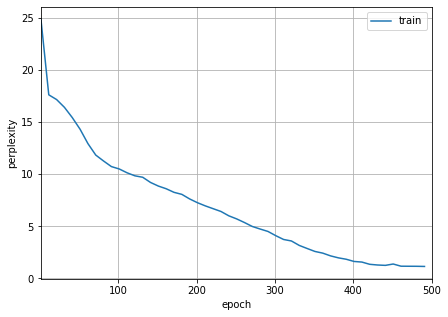

In [6]:
vocab_size, num_hiddens, ctx = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, ctx, get_lstm_params, init_lstm_state, lstm)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, ctx)

### 9.2.3 Concise Implementation
In `Gluon`, we can directly call the `LSTM` class in the `rnn` module. This encapsulates all the configuration details that we made explicit above. The code is significantly faster as it uses compiled operators rather than Python for many details that we spelled out in detail before.

Perplexity 1.2, 3557 tokens/sec on cpu(0)
time traveller  it s against reason said filby  what reason said
traveller corent of the fracm as mushed and said filby an a


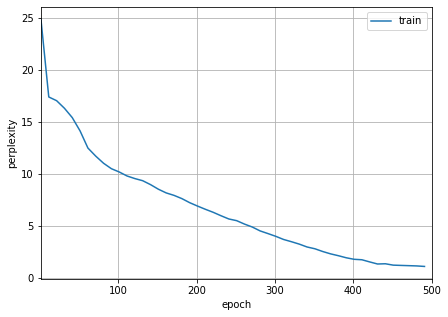

In [7]:
lstm_layer = rnn.LSTM(num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, ctx)

In many cases, `LSTM` perform slightly better than `GRU` but they are more costly to train and execute due to the larger latent state size. `LSTM` are the prototypical latent variable autoregressive model with nontrivial state control. Many variants thereof have been proposed over the years, e.g., multiple layers, residual connections, different types of regularization. However, training `LSTM` and other sequence models (such as `GRU`) are quite costly due to the long range dependency of the sequence. Later we will encounter alternative models such as `Transformers` that can be used in some cases.

##### Summary
+ `LSTM` have three types of gates: input gates, forget gates, and output gates which control the flow of information.
+ The hidden layer output of `LSTM` includes hidden states and memory cells. Only hidden states are passed into the output layer. Memory cells are entirely internal.
+ `LSTM` can cope with vanishing and exploding gradients.

##### Exercises
1. Adjust the hyperparameters. Observe and analyze the impact on runtime, perplexity, and the generated output.
2. How would you need to change the model to generate proper words as opposed to sequences of characters?
3. Compare the computational cost for GRUs, LSTMs, and regular RNNs for a given hidden dimension. Pay special attention to the training and inference cost.
4. Since the candidate memory cells ensure that the value range is between $-1$ and $1$ by using the $\tanh$ function, why does the hidden state need to use the $\tanh$ function again to ensure that the output value range is between $-1$ and $1$?
5. Implement an LSTM for time series prediction rather than character sequence prediction.